In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [4]:
df_TDis_ave = pd.DataFrame(columns=['Eddy', 'Cyc', 'ave_TDis', 'min_TDis', 'max_TDis'])
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy().dropna()
    if len(df) >= 30:
        df_TDis_ave.loc[len(df_TDis_ave)] = {'Eddy': eddy, 'Cyc': df.iloc[0].Cyc, 'ave_TDis': df.TiltDis.mean(),
                                            'min_TDis': df.TiltDis.min(), 'max_TDis': df.TiltDis.max()}
df_TDis_ave = df_TDis_ave.dropna()
df_TDis_ave_AE = df_TDis_ave[df_TDis_ave.Cyc=='AE']
df_TDis_ave_CE = df_TDis_ave[df_TDis_ave.Cyc=='CE']
df_TDis_ave


,Eddy,Cyc,ave_TDis,min_TDis,max_TDis
0,1,CE,18.334280,5.916888,35.643445
1,3,AE,25.958304,3.360780,65.152716
2,4,AE,20.438260,6.469600,38.791811
3,5,AE,8.881330,0.207956,25.653744
4,9,CE,51.219236,15.122806,115.417266
...,...,...,...,...,...
731,2610,CE,17.771266,2.905312,40.678656
732,2613,CE,19.577027,5.316149,33.157073
733,2616,AE,42.744605,6.683190,125.128425
734,2618,CE,32.762024,4.142747,80.791498


In [5]:
df_TDis_ave_AE.min_TDis.max()

np.float64(31.67748869743657)

In [6]:
def circular_mean_deg_true_north(deg):
    deg = np.asarray(deg)
    r = np.deg2rad(deg)
    C = np.mean(np.cos(r))
    S = np.mean(np.sin(r))
    return np.rad2deg(np.arctan2(S, C)) % 360 

df_TDir_ave = pd.DataFrame(columns=['Eddy', 'Cyc', 'ave_TDir'])
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy().dropna()
    if len(df) >= 30:
        df_TDir_ave.loc[len(df_TDir_ave)] = {'Eddy': eddy, 'Cyc': df.iloc[0].Cyc, 'ave_TDir': circular_mean_deg_true_north(df.TiltDir)}
df_TDir_ave = df_TDir_ave.dropna()
df_TDir_ave_AE = df_TDir_ave[df_TDir_ave.Cyc=='AE']
df_TDir_ave_CE = df_TDir_ave[df_TDir_ave.Cyc=='CE']
df_TDir_ave


,Eddy,Cyc,ave_TDir
0,1,CE,146.758651
1,3,AE,12.998739
2,4,AE,35.324900
3,5,AE,6.974525
4,9,CE,101.958121
...,...,...,...
731,2610,CE,234.821154
732,2613,CE,149.540113
733,2616,AE,97.705180
734,2618,CE,93.192149


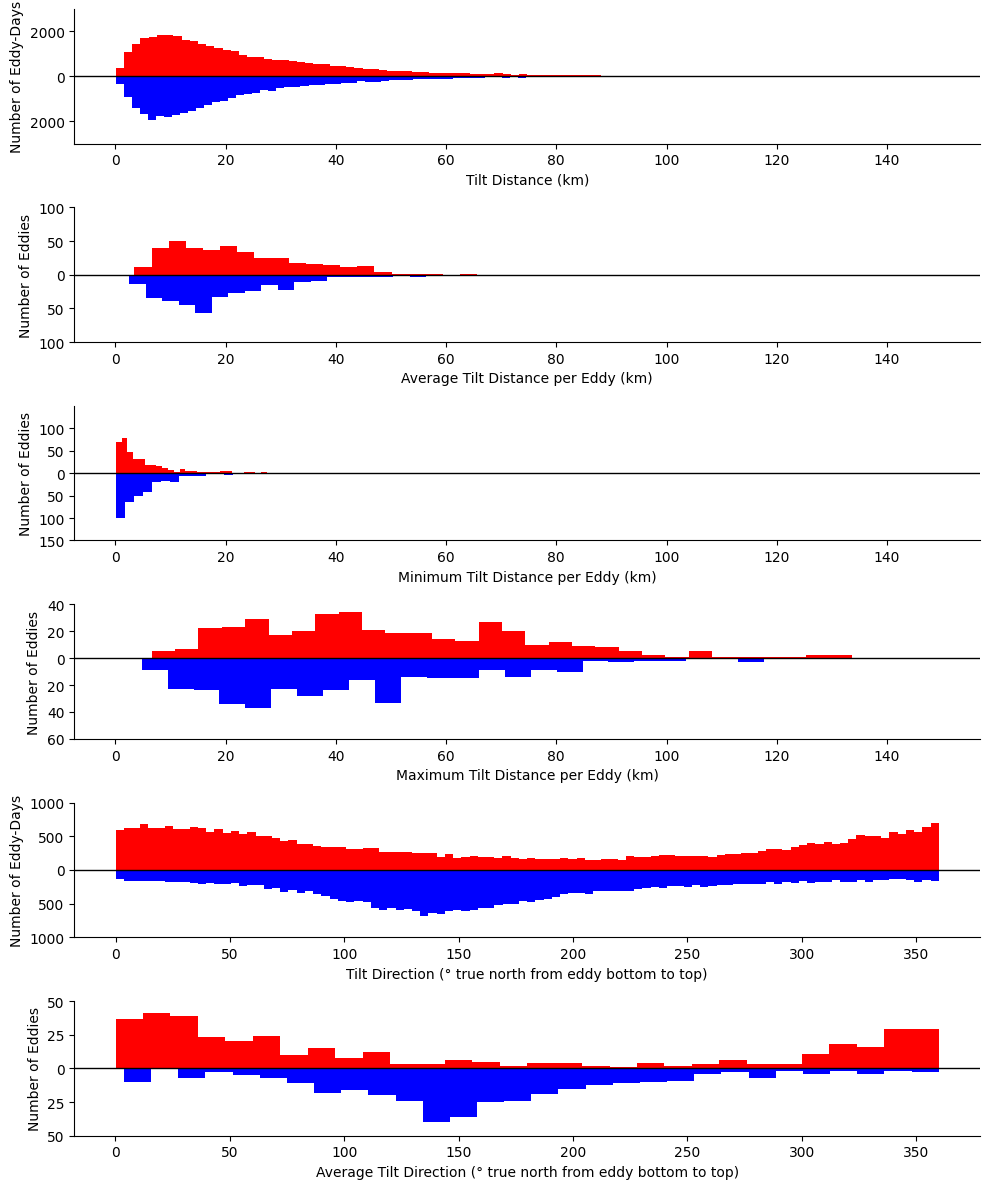

In [7]:
fig, axs = plt.subplots(6, 1, figsize=(10, 12))

# --- Plot 0 ---
ax = axs[0]
ages_ae = df_AE.TiltDis
ages_ce = df_CE.TiltDis
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Tilt Distance (km)')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
ax.set_ylim(-3000, 3000)

# --- Plot 1 ---
ax = axs[1]
bins = 20
ages_ae = df_TDis_ave_AE.ave_TDis
ages_ce = df_TDis_ave_CE.ave_TDis
ax.hist(ages_ae, bins=bins, color='r')
counts, bins = np.histogram(ages_ce, bins=bins)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Average Tilt Distance per Eddy (km)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-8000, 8000)
ax.set_xlim(axs[0].get_xlim())

# --- Plot 2 ---
ax = axs[2]
bins = 30
ages_ae = df_TDis_ave_AE.min_TDis
ages_ce = df_TDis_ave_CE.min_TDis
ax.hist(ages_ae, bins=bins, color='r')
counts, bins = np.histogram(ages_ce, bins=bins)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Minimum Tilt Distance per Eddy (km)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
ax.set_ylim(-150, 150)
ax.set_xlim(axs[0].get_xlim())

# --- Plot 3 ---
ax = axs[3]
bins = 30
ages_ae = df_TDis_ave_AE.max_TDis
ages_ce = df_TDis_ave_CE.max_TDis
ax.hist(ages_ae, bins=bins, color='r')
counts, bins = np.histogram(ages_ce, bins=bins)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Maximum Tilt Distance per Eddy (km)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-8000, 8000)
ax.set_xlim(axs[0].get_xlim())

# --- Plot 2 ---
ax = axs[4]
ages_ae = df_AE.TiltDir
ages_ce = df_CE.TiltDir
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Tilt Direction (° true north from eddy bottom to top)')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-8000, 8000)

# --- Plot 3 ---
ax = axs[5]
bins = 30
ages_ae = df_TDir_ave_AE.ave_TDir
ages_ce = df_TDir_ave_CE.ave_TDir
ax.hist(ages_ae, bins=bins, color='r')
counts, bins = np.histogram(ages_ce, bins=bins)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Average Tilt Direction (° true north from eddy bottom to top)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
ax.set_ylim(-50, 50)

plt.tight_layout()
plt.show()

